In [1]:
import numpy as np
import psi4
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt

In [2]:
### construct the input file to be used for psi4
z_mat = """-1 1
C
N 1 **R**"""

In [3]:
### creates a variety of points to be used in the PES
r_array = np.concatenate((np.linspace(0.9, 1.2, 20),np.linspace(1.25,1.75,10)))

In [82]:
### initializes the energy values for each method 
AUG_cc_pVTZ = []
cc_pVTZ = []
molecule_len = []

for val in r_array:
    molecule_geom = psi4.geometry(z_mat.replace('**R**', str(val)))
    molecule_len.append(molecule_geom)


for mol in molecule_len:
    energy = psi4.energy("CCSD/aug-cc-pVTZ", molecule=mol)
    AUG_cc_pVTZ.append(energy)
    energy = psi4.energy("CCSD/cc-pVTZ", molecule=mol)
    cc_pVTZ.append(energy)
    

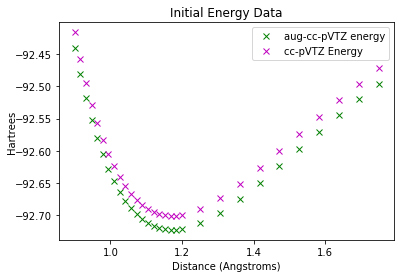

In [83]:
plt.plot(r_array,AUG_cc_pVTZ,'gx', label='aug-cc-pVTZ energy')
plt.plot(r_array,cc_pVTZ,'mx',label='cc-pVTZ Energy')
plt.legend(); plt.xlabel('Distance (Angstroms)'); plt.ylabel('Hartrees', labelpad=-2)
plt.title('Initial Energy Data'); plt.savefig('initial_energies.png', dpi=300)
plt.show()

In [84]:
### convert to A.U.
r_array_au = r_array*1.89
aug_spline = InterpolatedUnivariateSpline(r_array_au, AUG_cc_pVTZ, k=3)
cc_spline = InterpolatedUnivariateSpline(r_array_au, cc_pVTZ, k=3)

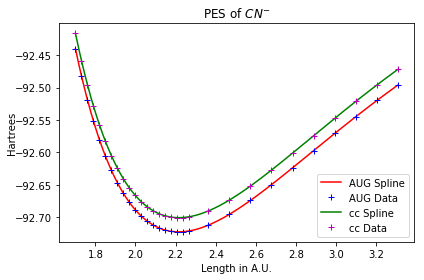

In [89]:
r_plot = np.linspace(0.9*1.89, 1.75*1.89, 250)
### computes the spline functions for two basis sets
inter_aug = aug_spline(r_plot)
inter_cc = cc_spline(r_plot)

### plots the spline functions and the original data for comparision
plt.figure()
plt.plot(r_plot, inter_aug, 'r-', label='AUG Spline')
plt.plot(r_array_au, AUG_cc_pVTZ, 'b+', label='AUG Data')
plt.plot(r_plot, inter_cc, 'g-', label='cc Spline')
plt.plot(r_array_au, cc_pVTZ, 'm+', label='cc Data')
plt.xlabel('Length in A.U.'); plt.ylabel('Hartrees',labelpad=-2); plt.legend()
plt.title('PES of $CN^{-}$'); plt.savefig('pes_comparison.png', dpi=300)
plt.tight_layout()
plt.show()

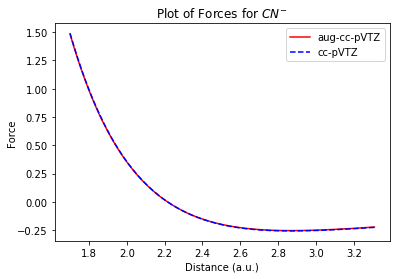

In [90]:
### compute the function for the force plot
aug_force_spline = aug_spline.derivative()
cc_force_spline = cc_spline.derivative()

### plot the force spline functions
plt.figure()
plt.plot(r_plot, -1*aug_force_spline(r_plot), 'r-', label='aug-cc-pVTZ')
plt.plot(r_plot, -1*cc_force_spline(r_plot), 'b--', label='cc-pVTZ')
plt.xlabel('Distance (a.u.)'); plt.ylabel('Force', labelpad=0)
plt.title('Plot of Forces for $CN^{-}$'); plt.legend()
plt.savefig('forces_plot.png', dpi=300)
plt.show()

In [91]:
### compute equilibrium bond length for both methods
aug_Req = r_plot[np.argmin(aug_spline(r_plot))]
cc_Req = r_plot[np.argmin(cc_spline(r_plot))]

print('The equilibrium bond length for the aug-cc-pVTz basis set is: {:.5f} Angstroms.'.format(aug_Req/1.89))
print('The equilibrium bond length for the cc-pVTZ basis set is:     {:.5f} Angstroms.'.format(cc_Req/1.89))

The equilibrium bond length for the aug-cc-pVTz basis set is: 1.17309 Angstroms.
The equilibrium bond length for the cc-pVTZ basis set is:     1.17309 Angstroms.


In [92]:
### compute the force splines for each basis set
aug_constant_spline = aug_force_spline.derivative()
cc_constant_spline = cc_force_spline.derivative()

aug_force_constant = aug_constant_spline(aug_Req)
cc_force_constant = cc_constant_spline(cc_Req)



print('{}\n{}'.format(aug_force_constant, cc_force_constant))

1.1185001895643518
1.127855559463423


In [93]:
### compute reduced mass
scalar = 1.6605E-27/9.109E-31
mC = 12.0107*scalar; mN = 14.0067*scalar
mEff = (mC*mN)/(mC+mN)

In [94]:
### Compute the vibrational frequencies in a.u.
aug_cc_nu = 1/(2*np.pi)*np.sqrt(aug_force_constant/mEff)
cc_nu = 1/(2*np.pi)*np.sqrt(cc_force_constant/mEff)

### Convert from a.u. to ev
aug_cc_nu_ev = 2 * np.pi* aug_cc_nu * 27.211
cc_nu_ev = 2* np.pi * cc_nu * 27.211


aug_freq = aug_cc_nu_ev * 241.8
cc_freq = cc_nu_ev * 241.8

print('{} THz\n{} THz'.format(aug_freq, cc_freq))

64.09359249172057 THz
64.36108044238557 THz


In [95]:
print(F'{2230 * 2.998E10:.6e} Hz')
print(F'{aug_freq*1E12:.6e} Hz')
print(F'{cc_freq*1E12:.6e} Hz')

6.685540e+13 Hz
6.409359e+13 Hz
6.436108e+13 Hz
